# MNEflow basic calssification example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [3]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow


fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

SyntaxError: EOL while scanning string literal (<ipython-input-3-18e7d95939e4>, line 9)

### Convert epochs to TFRecord format

In [2]:
#Specify import options
import_opt = dict(savepath='C://data//tfr//',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords([epochs], **import_opt)  

processing epochs
input shapes: X- (940, 204, 361) targets- (940, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (940, 1, 361, 204) (940, 8) folds: 6 x 156
Prepocessed sample shape: (1, 361, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


## Other import options
### 1.2 Saved mne.epochs (*-epo.fif) files
Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files

e.g. this will work

```python
epochs.save('test_saved_epochs.fif')
meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)
```
### 1.3. Arrays in *.mat or *.npz format
if the first argument is str mneflow.produce_tfrecords can also accept *.mat or *.npz format

e.g.

```python
data_path = '.../data_path/'
filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
meta = mneflow.produce_tfrecords(filenames,**opt)
```
In this case, specify iput_type='array', and also provide array_keys keyword argument

e.g. 

```python
array_keys={'X':'my_data_samples','y':'my_labels'}
```

### 1.4. Tuple of (data, labels)
Finally, if you have a more complex preprocessing pipeline, you can feed you data and labels as a tuple of arrays

```python
X = epochs.get_data()
y = epochs.events[:,2]
meta = mneflow.produce_tfrecords((X,y),**opt)
```


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [3]:
dataset = mneflow.Dataset(meta, train_batch=100)

# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. computational graph

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.models.BaseModel for more details.
In this example will we use LF-CNN network


In [4]:
# specify model parameters
lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 361, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 361, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 73, 32)
Input shape: (1, 361, 204)
y_pred: (None, 8)
Initialization complete!


Epoch 1/25
100/100 - 10s - loss: 5.3282 - cat_ACC: 0.1870 - val_loss: 4.9735 - val_cat_ACC: 0.2222
Epoch 2/25
100/100 - 10s - loss: 4.6453 - cat_ACC: 0.3497 - val_loss: 4.5041 - val_cat_ACC: 0.3333
Epoch 3/25
100/100 - 10s - loss: 4.0264 - cat_ACC: 0.5295 - val_loss: 4.0088 - val_cat_ACC: 0.5159
Epoch 4/25
100/100 - 10s - loss: 3.4969 - cat_ACC: 0.6704 - val_loss: 3.5531 - val_cat_ACC: 0.6032
Epoch 5/25
100/100 - 10s - loss: 3.0162 - cat_ACC: 0.7967 - val_loss: 3.1399 - val_cat_ACC: 0.6984
Epoch 6/25
100/100 - 10s - loss: 2.6471 - cat_ACC: 0.8750 - val_loss: 2.8142 - val_cat_ACC: 0.7302
Epoch 7/25
100/100 - 10s - loss: 2.3565 - cat_ACC: 0.9115 - val_loss: 2.5516 - val_cat_ACC: 0.7619
Epoch 8/25
100/100 - 10s - loss: 2.1047 - cat_ACC: 0.9400 - val_loss: 2.3333 - val_cat_ACC: 0.7857
Epoch 9/25
100/100 - 10s - loss: 1.8865 - cat_ACC: 0.9567 - val_loss: 2.1376 - val_cat_ACC: 0.7857
Epoch 10/25
100/100 - 10s - loss: 1.7041 - cat_ACC: 0.9621 - val_loss: 1.9711 - val_cat_ACC: 0.7857
Epoch 11/

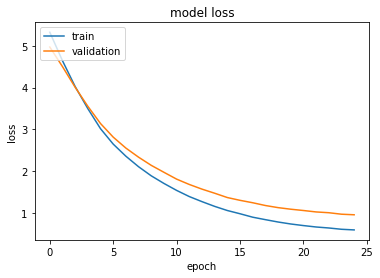

In [5]:
#train the model for 10 epochs
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [6]:
test_loss, test_acc = model.evaluate(meta['test_paths'])

1/1 [==============================] - 0s 2ms/step - loss: 0.7832 - cat_ACC: 0.8910


# 4. Explore the trained model parameters
LF-CNN allows exploring parameters learned from the data in terms of toporaphies and the spectral properties of the latent sources contributing to each class

In [7]:
model.compute_patterns()


Computing patterns: No path specified, using validation dataset (Default)


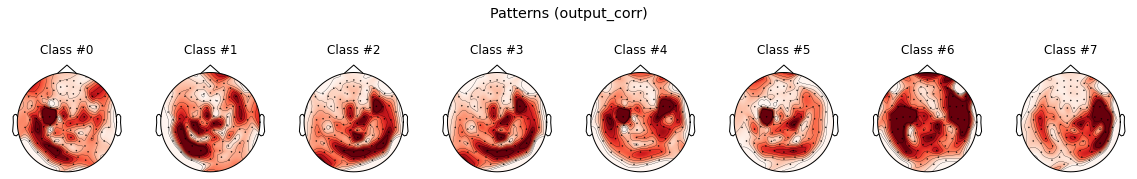

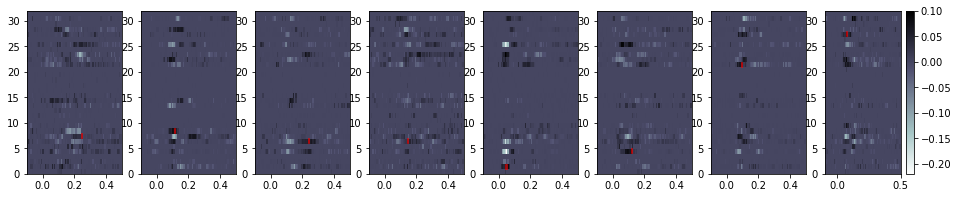

In [8]:

f1 = model.plot_patterns(info=epochs.info, sorting='output_corr')

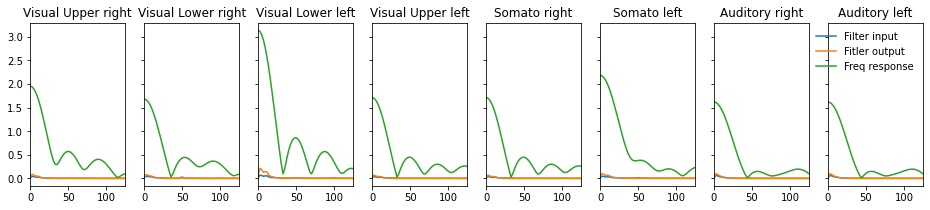

In [9]:
f2 = model.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=condition_names)

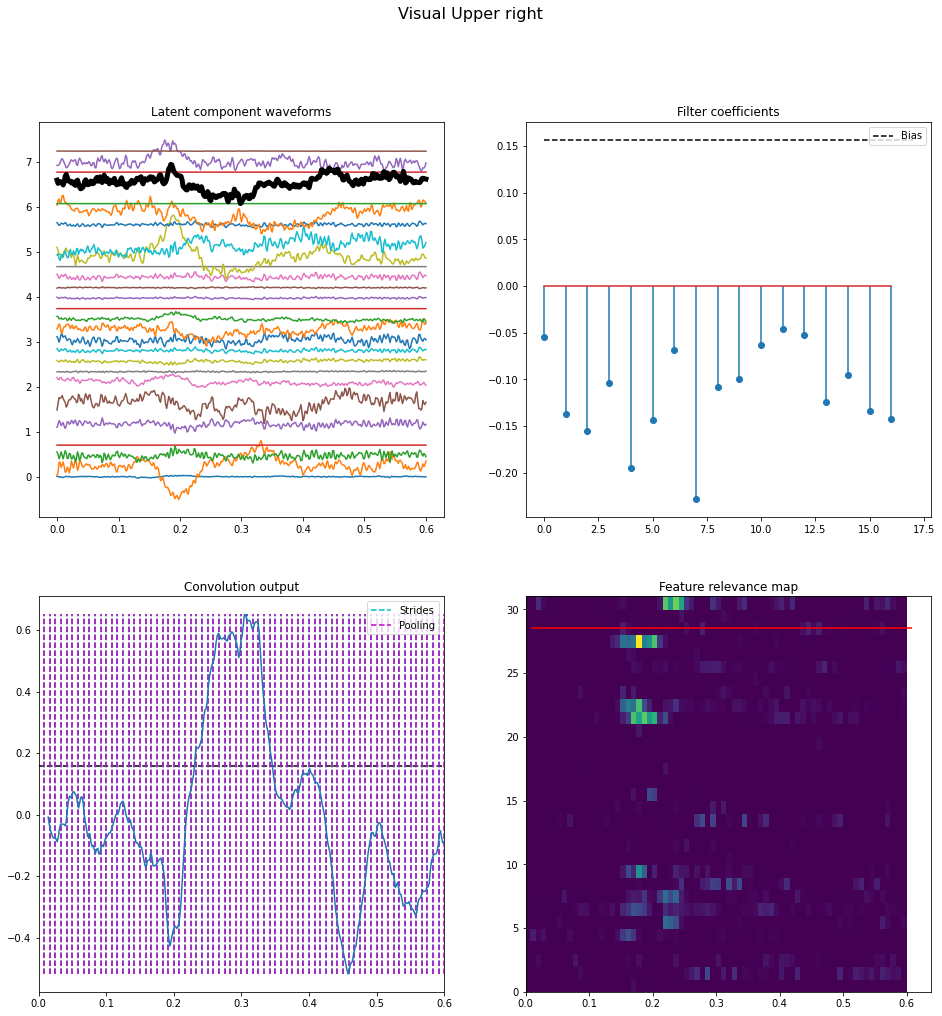

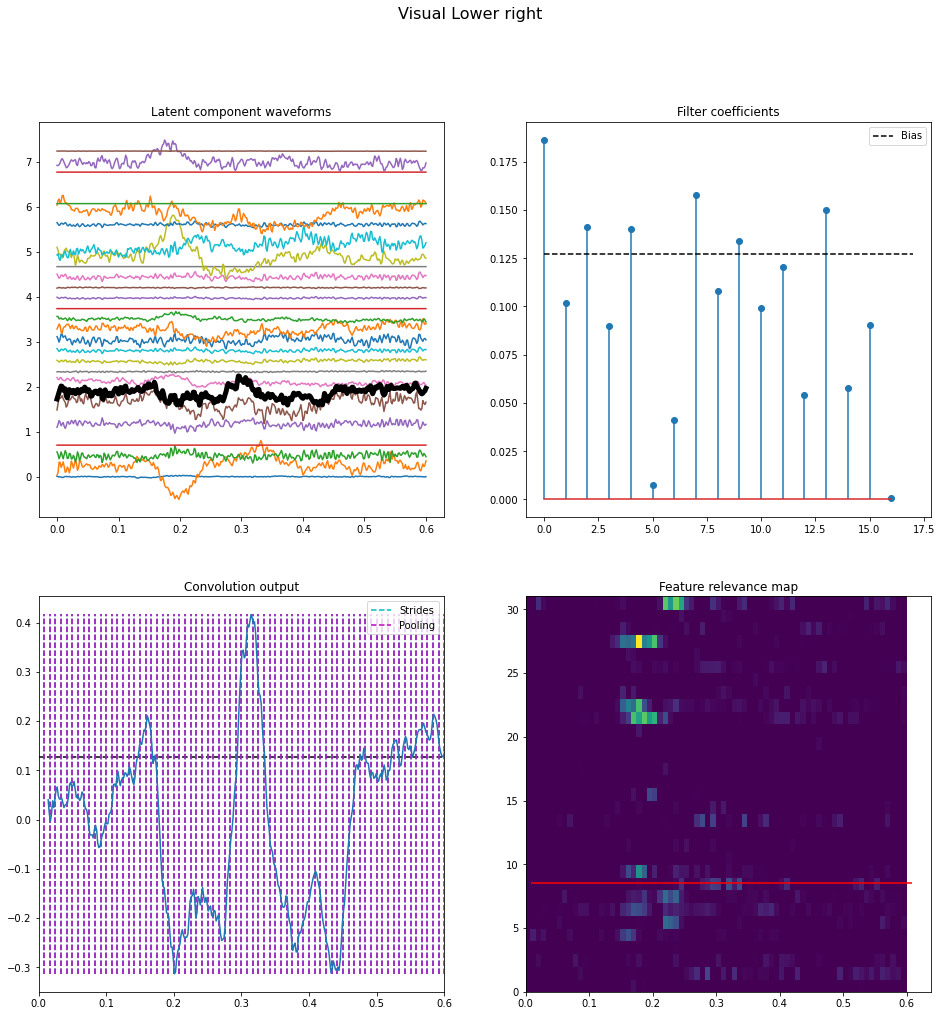

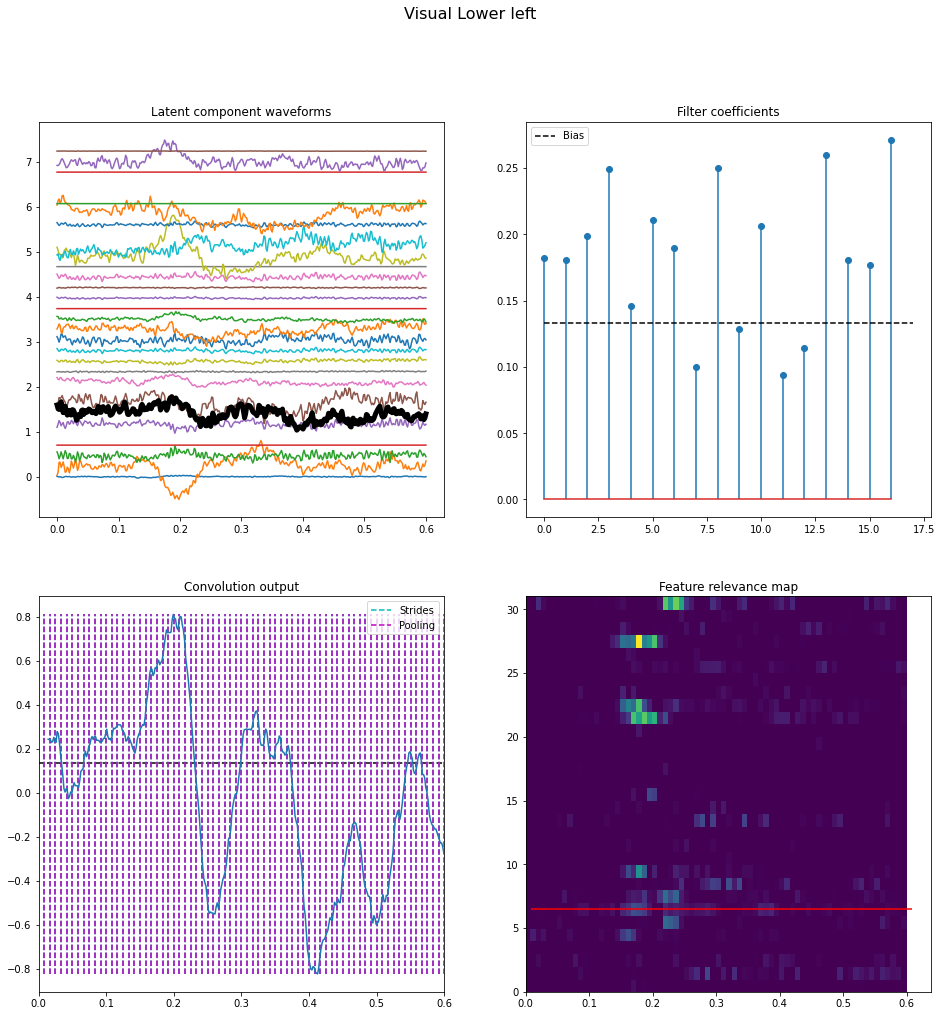

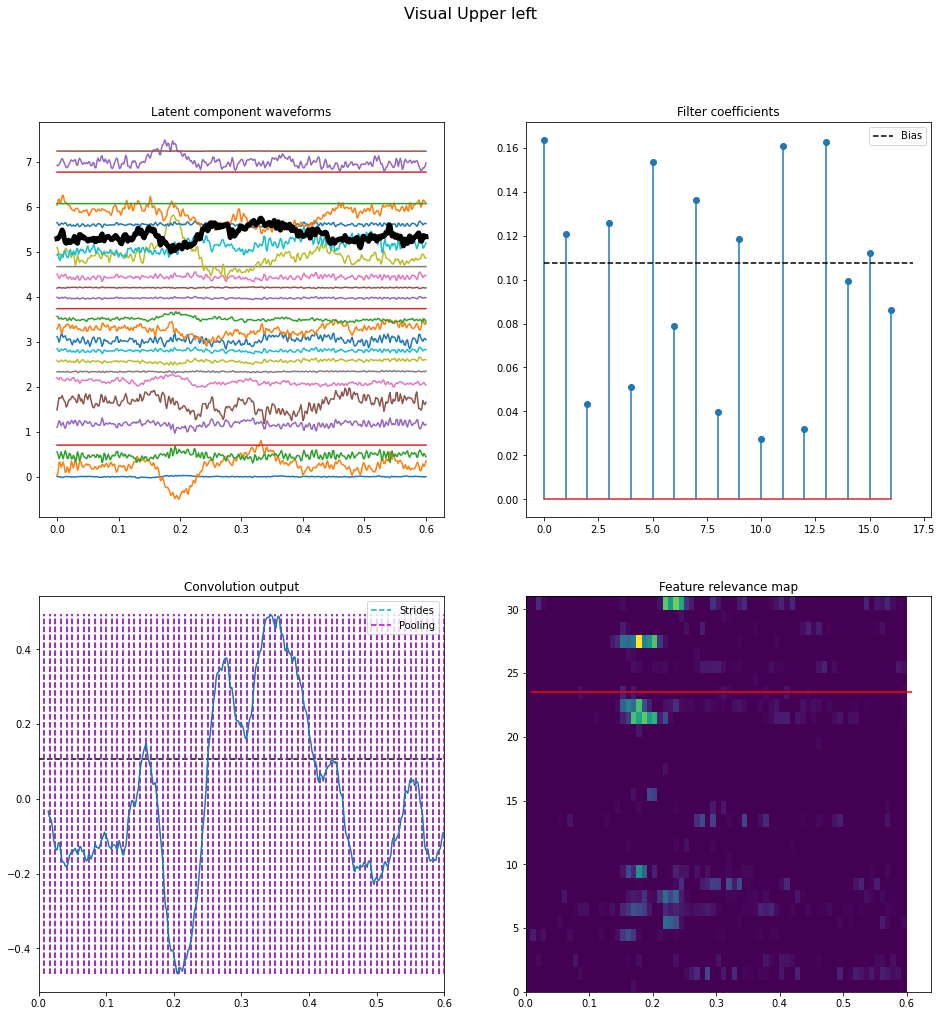

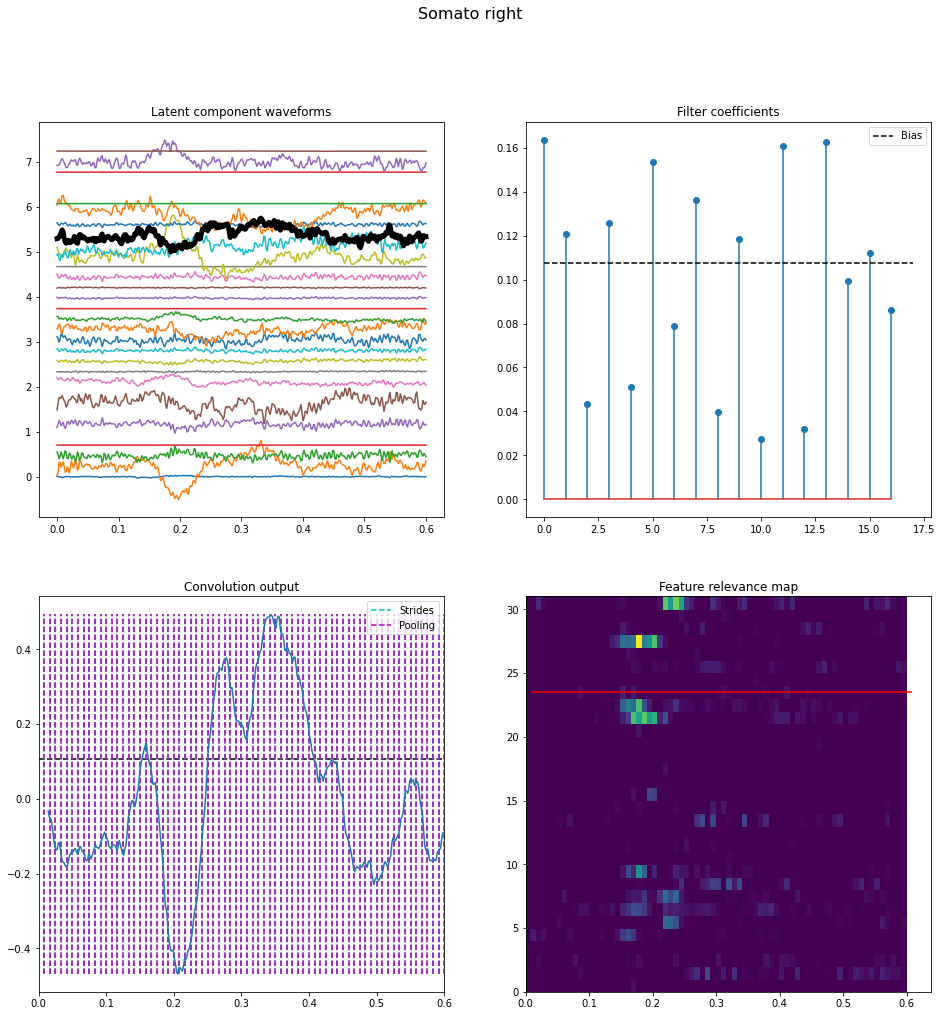

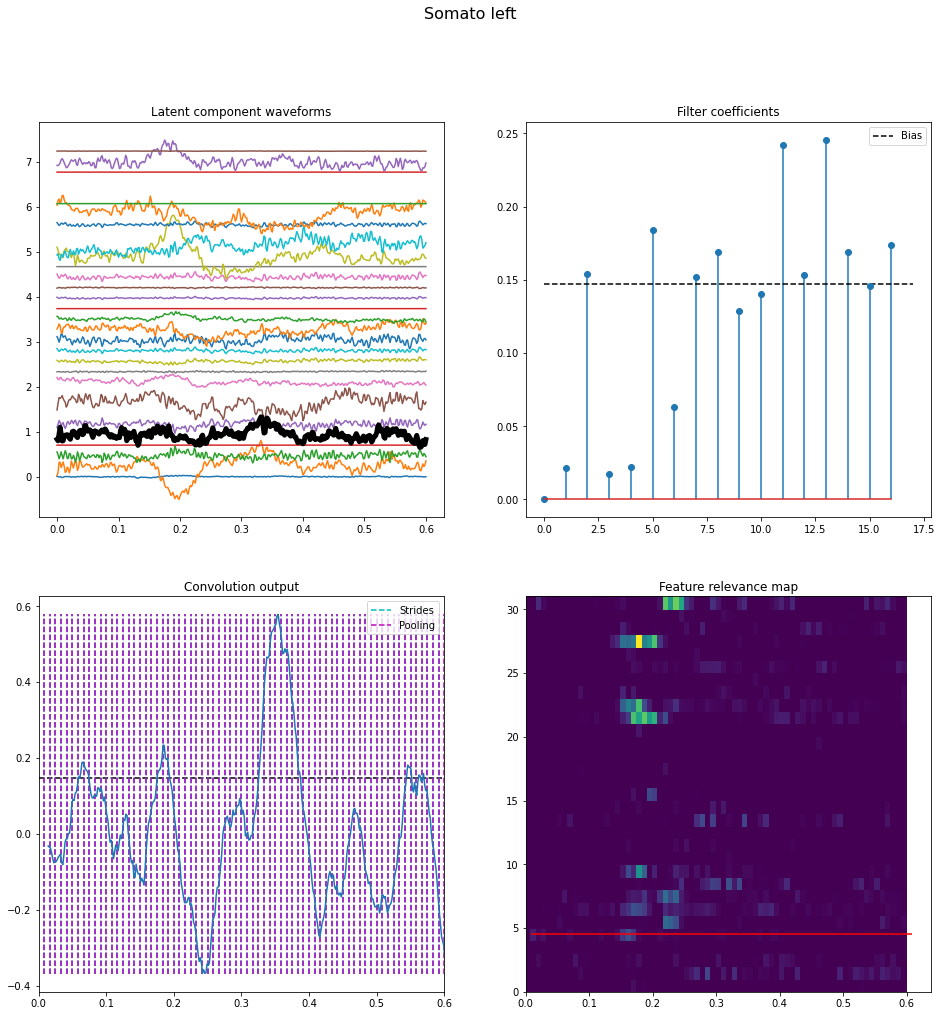

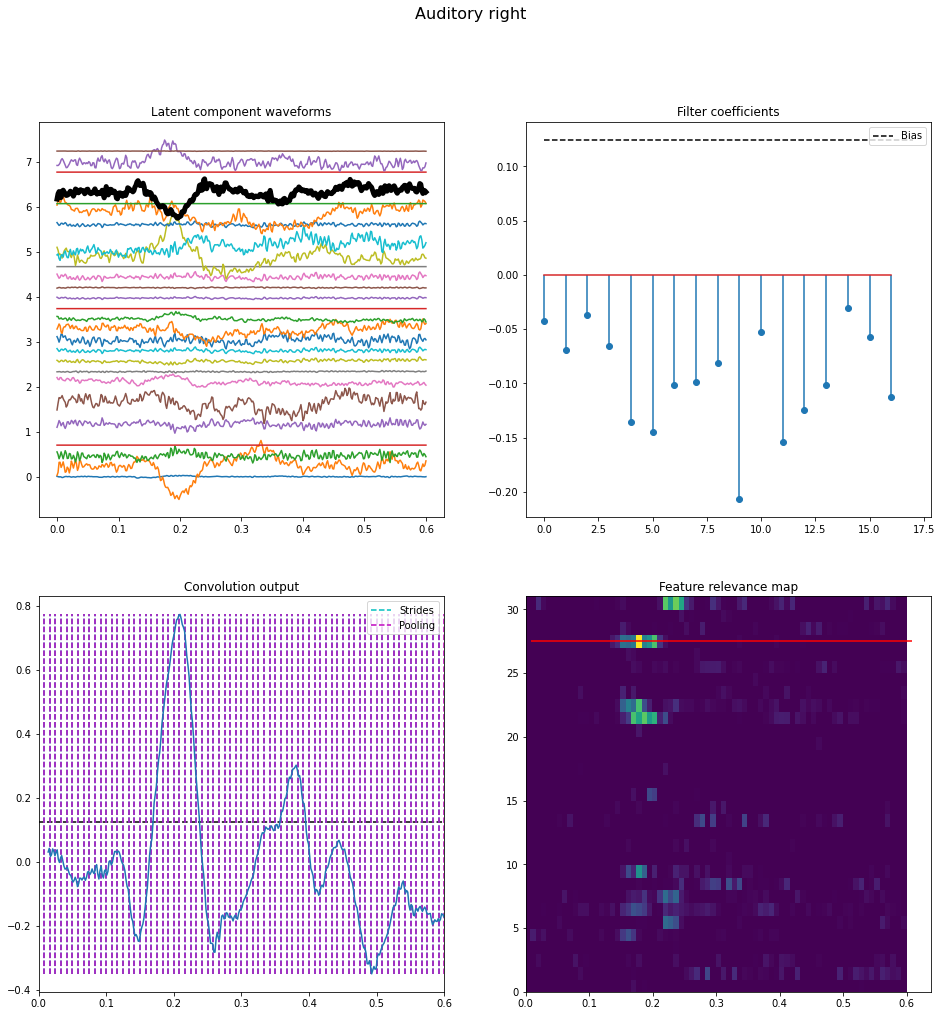

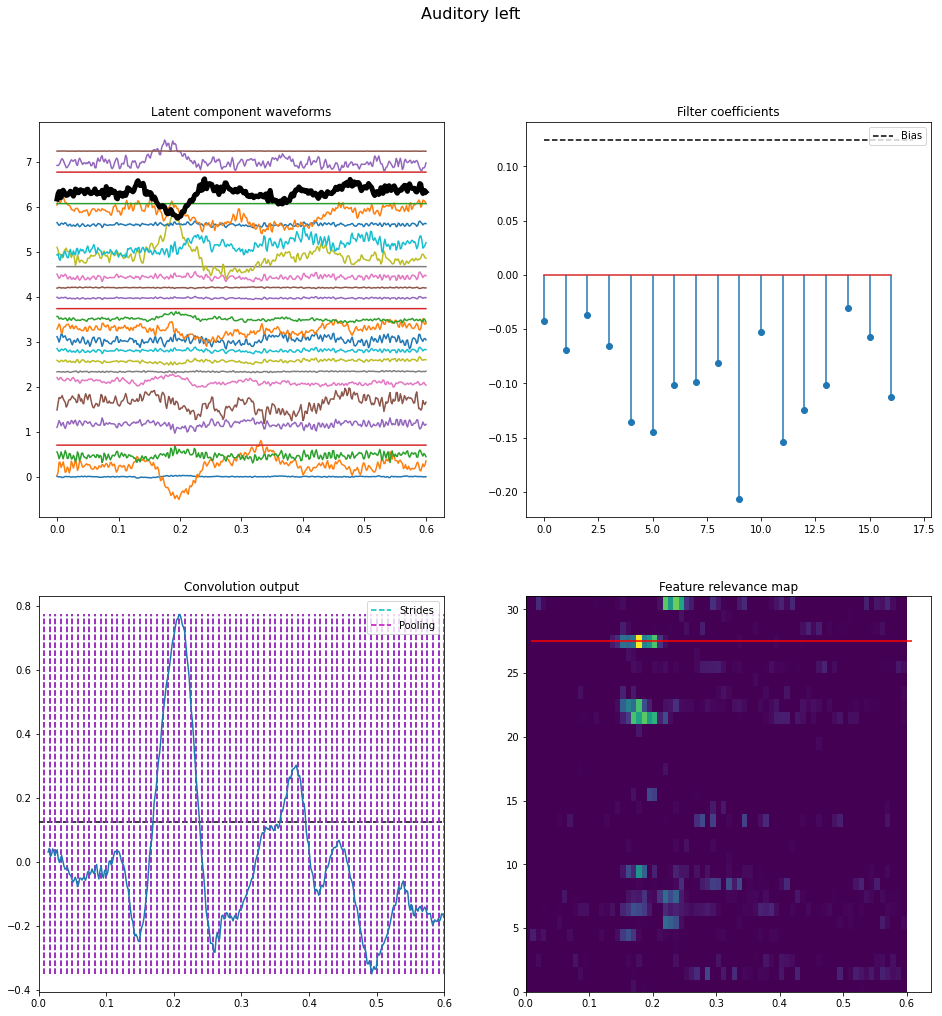

In [10]:
f3 = model.plot_waveforms(sorting='compwise_loss', class_names=condition_names)